In [105]:
!pip install pydicom

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [106]:
import sagemaker
import boto3
import pandas
from sagemaker import get_execution_role

import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files

In [107]:
region = boto3.Session().region_name
session = sagemaker.Session()

#https://siim-covid19-detection.s3.amazonaws.com/
bucket = 'siim-covid19-detection'

role = get_execution_role()
sm = boto3.Session().client(service_name='sagemaker',region_name=region)
s3 = boto3.resource('s3')

## Dataset Information
The train dataset comprises 6,334 chest scans in DICOM format, which were de-identified to protect patient privacy. All images were labeled by a panel of experienced radiologists for the presence of opacities as well as overall appearance.

Note that all images are stored in paths with the form study/series/image. The study ID here relates directly to the study-level predictions, and the image ID is the ID used for image-level predictions.

The hidden test dataset is of roughly the same scale as the training dataset.

### train_image_level.csv
The train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes. <br>
`id` - unique image identifier <br>
`boxes` - bounding boxes in easily-readable dictionary format <br>
`label` - the correct prediction label for the provided bounding boxes

In [108]:
s3.Bucket(bucket).download_file('train_image_level.csv', 'train_image_level.csv')
train_image_level_pd = pd.read_csv('train_image_level.csv')

In [109]:
train_image_level_pd.shape

(6334, 4)

In [110]:
train_image_level_pd.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


### train_study_level.csv
The train study-level metadata, with one row for each study, including correct labels. <br>
`id` - unique study identifier <br>
`Negative for Pneumonia` - 1 if the study is negative for pneumonia, 0 otherwise <br>
`Typical Appearance` - 1 if the study has this appearance, 0 otherwise <br>
`Indeterminate Appearance`  - 1 if the study has this appearance, 0 otherwise <br>
`Atypical Appearance`  - 1 if the study has this appearance, 0 otherwise <br>

In [111]:
s3.Bucket(bucket).download_file('train_study_level.csv', 'train_study_level.csv')
train_study_level_pd = pd.read_csv('train_study_level.csv')

In [112]:
train_study_level_pd.shape

(6054, 5)

In [113]:
train_study_level_pd.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


### Exploring a sample image

In [114]:
study_id = '00086460a852'
image_id = '65761e66de9f'
series_id = '9e8302230c91'

sample_image_path_s3 = 'test/'+study_id+'/'+series_id+'/'+image_id+'.dcm'
local_image = 'sample_image.dcm'

In [115]:
train_image_level_pd.loc[train_image_level_pd['id'] == image_id + '_image']

,id,boxes,label,StudyInstanceUID
2498,65761e66de9f_image,"[{'x': 720.65215, 'y': 636.51048, 'width': 332...",opacity 1 720.65215 636.51048 1052.84563 1284....,00086460a852


In [116]:
train_study_level_pd.loc[train_study_level_pd['id'] == study_id + '_study']

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0


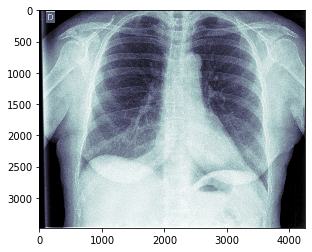

In [117]:
s3.Bucket(bucket).download_file(sample_image_path, local_image)
ds = pydicom.dcmread(local_image)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

## Exploratory Data Analysis/ Pre-processing

In [ ]:
# todo

## SageMaker Training

In [ ]:
from sagemaker.pytorch import PyTorch

train_data_s3 = #todo
model_arch = # todo 

In [ ]:
#todo
estimator = PyTorch(
    entry_point= #todo,
    role=role,
    py_version='py3',
    framework_version="1.8.1",
    instance_count=1,
    instance_type="", #todo
    hyperparameters={'epochs': 10,
                     'backend': 'nccl',
                     'model-type': model_arch,
                     'lr': 0.001,
                     'batch-size': 64
                    }
)

In [ ]:
data_channels = {'train': sagemaker.inputs.TrainingInput(
                          s3_data_type='S3Prefix',
                          s3_data=train_data_s3,
                          content_type='image/jpeg',
                          input_mode='File'),
                 
                  'val': sagemaker.inputs.TrainingInput(
                         s3_data_type='S3Prefix',
                         s3_data=train_data_s3,
                         content_type='image/jpeg',
                         input_mode='File')
}

In [ ]:
train_estimator.fit(inputs=data_channels)

## SageMaker Inference

In [ ]:
predictor_endpoint = train_estimator.deploy(initial_instance_count=1, 
                                            instance_type= #todo)
response = predictor_endpoint.predict(#todo)
print(response)

In [ ]:
predictor_endpoint.delete_endpoint()